In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

from matplotlib import pyplot
import seaborn as sns
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [2]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [3]:
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

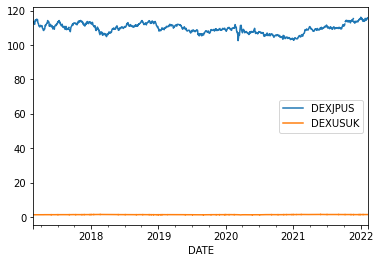

In [4]:
ccy_data.plot();

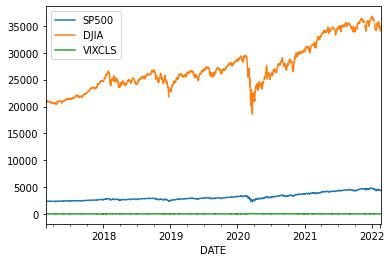

In [5]:
idx_data.plot();

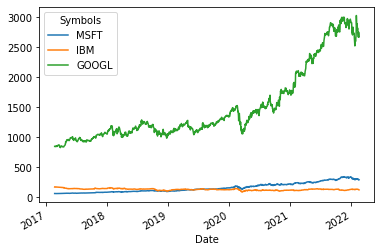

In [6]:
stk_data['Open'].plot();

In [7]:
return_period = 5

In [8]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

In [9]:
Y.name = 'MSFT_pred'

In [10]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, 
                                                                            return_period * 3, 
                                                                            return_period * 6, 
                                                                            return_period * 12]
          ], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X = pd.concat([X1,X2,X3,X4], axis=1)

dataset = pd.concat([X,Y], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

### 3. Exploratory Data Analysis

#### 3.1 Descriptive Statistics

In [11]:
pd.set_option('precision', 3)
dataset.describe()

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
count,225.000,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,0.004,0.002,1.491e-04,1.707e-04,0.003,0.002,0.002,0.007,0.020,0.039,0.085,0.006
std,0.036,0.039,1.043e-02,1.359e-02,0.027,0.029,0.168,0.032,0.056,0.064,0.073,0.033
min,-0.131,-0.173,-5.226e-02,-6.616e-02,-0.141,-0.167,-0.442,-0.137,-0.240,-0.299,-0.143,-0.137
25%,-0.017,-0.014,-5.303e-03,-6.979e-03,-0.008,-0.009,-0.103,-0.011,-0.006,0.011,0.042,-0.014
50%,0.007,0.003,7.047e-04,-6.658e-04,0.005,0.005,-0.017,0.009,0.022,0.045,0.090,0.008
75%,0.025,0.021,5.920e-03,7.634e-03,0.015,0.016,0.089,0.023,0.048,0.078,0.132,0.026
max,0.096,0.175,5.273e-02,7.540e-02,0.160,0.183,0.651,0.164,0.245,0.207,0.293,0.164


In [12]:
dataset.head()

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
2017-05-17,-0.013,-0.002,-0.023,3.864e-04,-1.791e-02,-0.016,0.423,-0.021,5.423e-04,0.032,0.051,0.019
2017-05-24,0.037,0.010,0.005,-6.955e-04,1.989e-02,0.019,-0.442,0.019,1.218e-03,0.055,0.078,0.019
2017-06-01,0.011,0.001,-0.004,-4.643e-03,6.188e-03,0.003,-0.010,0.019,1.705e-02,0.081,0.091,0.026
2017-06-09,-0.026,0.013,0.001,-1.155e-02,-2.997e-03,0.003,0.093,-0.020,3.782e-02,0.035,0.088,-0.005
2017-06-16,-0.012,0.008,0.002,3.214e-03,5.673e-04,0.005,-0.030,-0.005,5.443e-03,0.023,0.079,0.017


#### 3.2 Data Visualization

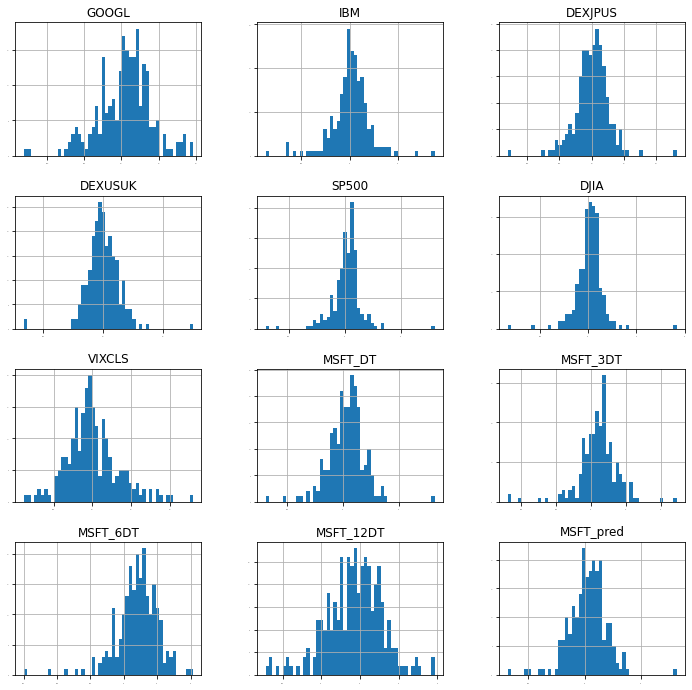

In [13]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12));

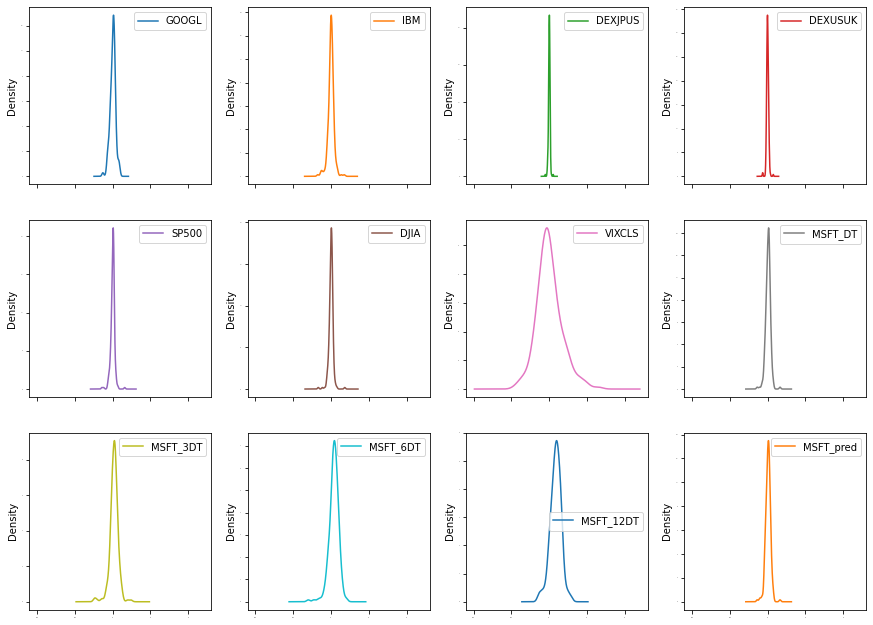

In [14]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15));

<AxesSubplot:title={'center':'Correlation Matrix'}>

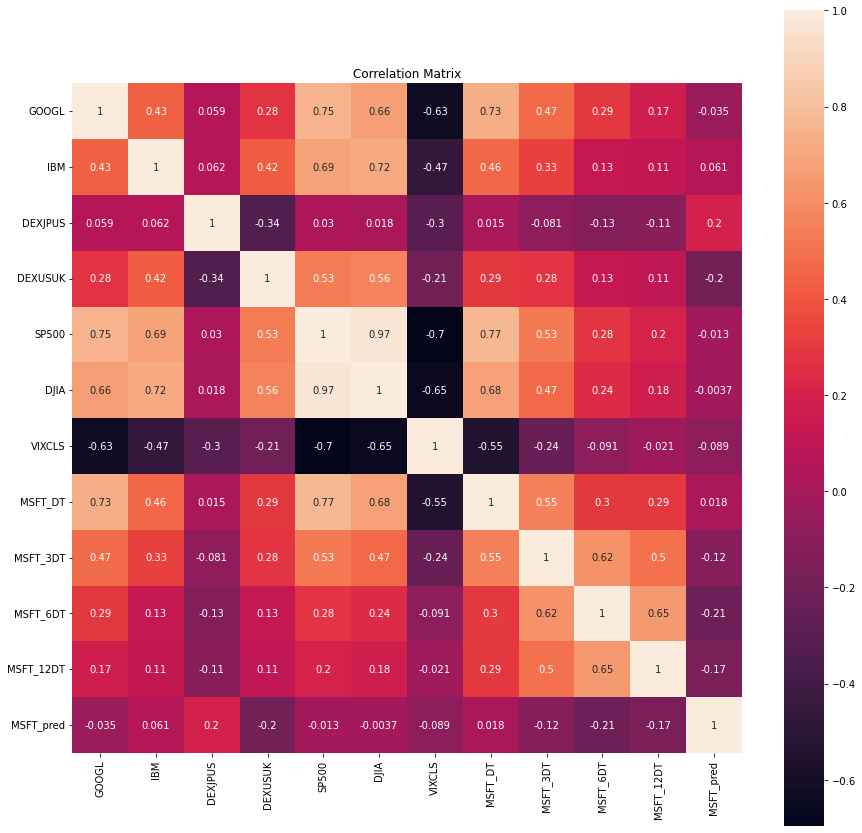

In [15]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='rocket')
# https://seaborn.pydata.org/tutorial/color_palettes.html

<Figure size 1080x1080 with 0 Axes>

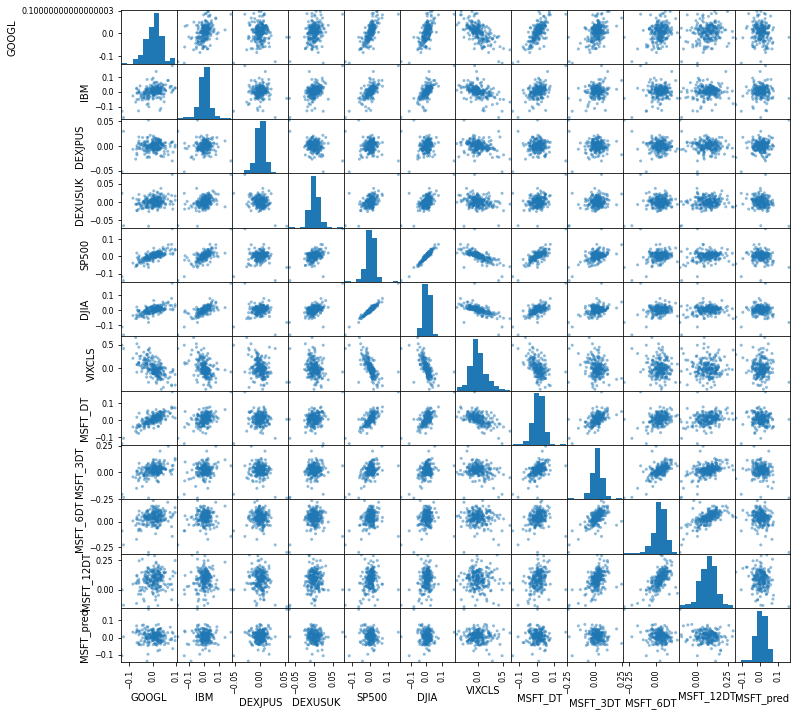

In [16]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12));

#### 3.3 Time Series Analysis

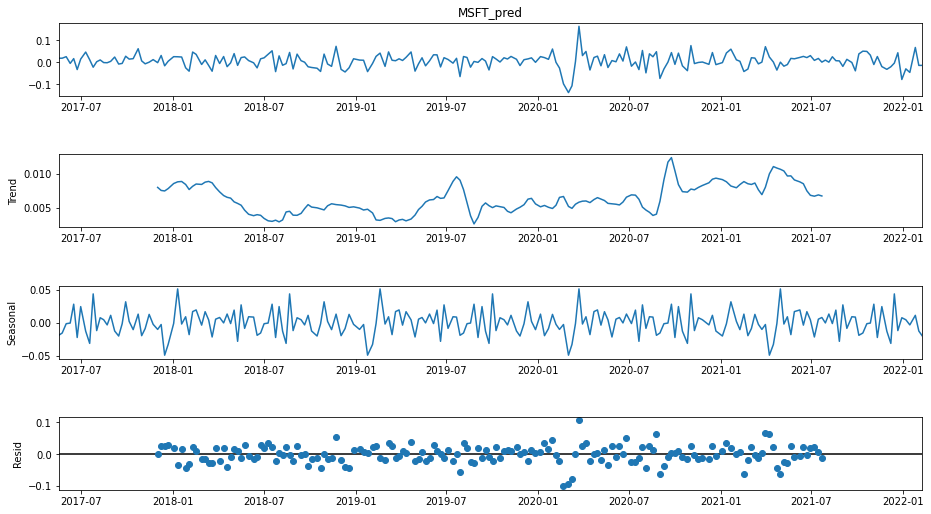

In [17]:
# sm.tsa.seasonal_decompose(data_web['High']['MSFT'], freq=30)
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)

### 4. Data Preparation

In [18]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_6DT,10.621
DEXJPUS,9.054
DEXUSUK,8.819
MSFT_12DT,6.536
MSFT_3DT,3.452
VIXCLS,1.764
IBM,0.822
GOOGL,0.270
MSFT_DT,0.072
